# CSE 572: Lab 7

In this lab, you will practice implementing techniques for dimensionality reduction using Kernel PCA and autoencoder neural networks.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button.

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Kernel PCA

Principal component analysis (PCA) is a classical method for reducing the dimensionality (number of attributes) in the data by projecting the data from its original high-dimensional space into a lower-dimensional space. The conventional formulation of PCA is limited to finding a linear projection of the data, so if the original data are not linearly separable then the PCA-projected data also will not be. Kernel PCA is a simple modification of PCA that uses kernel functions to project data into a higher-dimensional space where it may become linearly separable and compute PCA in the higher-dimensional space, using special kernel functions to make this computation feasible.

In this section, we will apply Kernel PCA to the image dataset.

### Load the dataset

We will use a preprocessed subset of the “Labeled Faces in the Wild” (LFW) dataset, which you can read more about [here](http://vis-www.cs.umass.edu/lfw/).

In [ ]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70)

# data attribute gives the data matrix with the image dimension flattened
X = lfw_people.data
print('Num samples: {}'.format(X.shape[0]))
print('Num features: {}'.format(X.shape[1]))

# images attribute gives the unflattened image dimension
print('Image dimensions: {} x {}'.format(lfw_people.images.shape[1], lfw_people.images.shape[2]))

# the label to predict is the id of the person
y = lfw_people.target
# target_names attribute tells us the name of the person associated with each id
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print('Num classes: {}'.format(n_classes))
print('Class names:', target_names)

Num samples: 1288
Num features: 2914
Image dimensions: 62 x 47
Num classes: 7
Class names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


The dataset has 1,288 images of the faces of 7 different people. The code below prints the number of samples from each class.

In [ ]:
for i in range(n_classes):
    print('Number of instances in class {} ({}): {}'.format(i,
                                                            target_names[i],
                                                            y[y==i].shape[0]
                                                           ))

Number of instances in class 0 (Ariel Sharon): 77
Number of instances in class 1 (Colin Powell): 236
Number of instances in class 2 (Donald Rumsfeld): 121
Number of instances in class 3 (George W Bush): 530
Number of instances in class 4 (Gerhard Schroeder): 109
Number of instances in class 5 (Hugo Chavez): 71
Number of instances in class 6 (Tony Blair): 144


To get an idea of what is in our dataset, we visualize a random face from each class below. (Note: You can run this cell many times to see different random examples.)

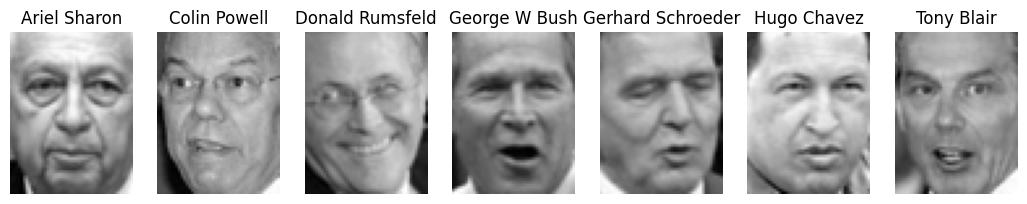

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=n_classes, figsize=(13,6))

for i in range(n_classes):
    rand_ind = np.random.randint(0, y[y==i].shape[0])
    axes[i].imshow(lfw_people.images[y==i][rand_ind], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(target_names[i])

Next, we will split the data into training and test subsets, using 30\% of the data for testing.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Next we standardize the data so that the mean of all attributes is 0 using the StandardScaler() object in scikit-learn to standardize the data. We fit the scaler to the training data and apply it to both the training and test data.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Kernel PCA

Kernel PCA uses one of several choices of kernel functions to transform the data into a higher-dimensinoal space and then compute the principal components (eigenvectors) of the data in the high-D space. We then use these principal components to transform the data into a new set of features that maximizes variance in the dataset.

The KernelPCA class in scikit-learn gives four options for kernel functions (the same functions available for SVM): 'poly', 'rbf', 'sigmoid', and 'cosine'. In the code below, we implement KernelPCA using 10 principal components and the sigmoid kernel.

In [ ]:
from sklearn.decomposition import KernelPCA

n_components = 10

kpca = KernelPCA(n_components=n_components, kernel='sigmoid', fit_inverse_transform=True).fit(X_train)

We can use our PCA model (i.e., the principal component vectors found in our data) to transform our dataset into the new reduced-dimensional space. This is done in the below code using the `transform()` function.

In [ ]:
X_train_kpca = kpca.transform(X_train)
X_test_kpca = kpca.transform(X_test)

### SVM classifier with Kernel PCA

Now that we've reduced the dimensionality of our dataset from 2914 to 10, we can use these new features as our inputs for classification. In this example, we'll use a Support Vector Machine (SVM) classifier. In the cell below, train an SVM with `C=10000` and `kernel='rbf'`.

In [ ]:
from sklearn.svm import SVC

clf = SVC(C=10, kernel='rbf')
clf = clf.fit(X_train_kpca, y_train)

In the cell below, use the trained model to make predictions for the test set.

In [ ]:
y_pred = clf.predict(X_test_kpca)

The next cell shows how we can use the `classification_report()` function in sklearn to print several metrics computed for the test set.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.06      0.06      0.06        18
     Colin Powell       0.46      0.52      0.49        69
  Donald Rumsfeld       0.47      0.44      0.45        34
    George W Bush       0.68      0.77      0.72       166
Gerhard Schroeder       0.53      0.29      0.38        31
      Hugo Chavez       0.27      0.21      0.24        19
       Tony Blair       0.39      0.30      0.34        50

         accuracy                           0.54       387
        macro avg       0.41      0.37      0.38       387
     weighted avg       0.52      0.54      0.52       387



We can also use the `ConfusionMatrixDisplay` object to visualize the confusion matrix for the test set predictions.

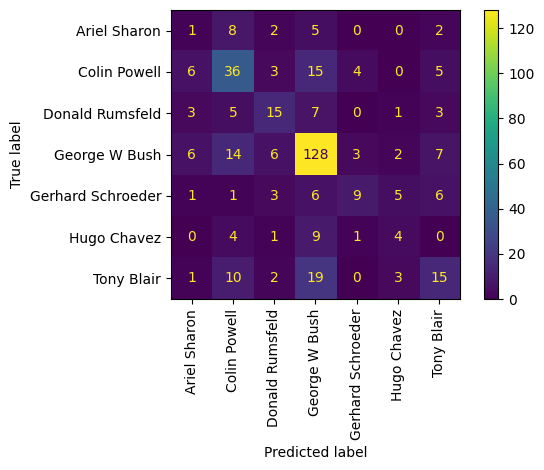

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    clf, X_test_kpca, y_test, display_labels=target_names, xticks_rotation="vertical"
)

plt.tight_layout()
plt.show()

**Question 1: What is the difference between the covariance matrix and the confusion matrix? What are the dimensions of each in terms of the number of attributes (m) and the number of classes (c)? How are each used here?**

**Answer:**
*   Covariance Matrix:

    The covariance matrix is used to represent the covariance (a measure of how much two random variables vary together) between every pair of attributes in the data.

    The covariance matrix is used in PCA (and Kernel PCA) to find the principal components that represent the directions in the attribute space along which the data varies the most.

*   Confusion Matrix:

    The confusion matrix is used in classification to visualize the performance of an algorithm. Each row of the matrix represents the instances of the predicted class, while each column represents the instances of the actual class.

    In Kernel PCA and SVM classifier, the confusion matrix is used to evaluate the performance of the SVM classifier. It shows how many instances of each class were correctly or incorrectly classified by the SVM after dimensionality reduction through Kernel PCA.

Here, there are m = 2914 attributes (dimensionality of the data before PCA) and c = 7 classes (the number of different people in the dataset). Thus, the covariance matrix would have been 2914 x 2914 if computed on the original data, while the confusion matrix as seen in the output is 7 x 7.


### Data reconstruction

We can reconstruct the original input images by multiplying the encoded data in the principal subspace by the principal component vectors. This reverse transformation is called the *inverse transform*. The code below reconstructs the original data using the KernelPCA `inverse_transform()` function.

In [ ]:
train_recon_kpca = kpca.inverse_transform(X_train_kpca)
test_recon_kpca = kpca.inverse_transform(X_test_kpca)

Create a plot to visualize the original image and reconstructed image for the first 5 images in the test set. Plot the original images on the first row and the reconstructions on the second row. Print the class name as the title for each original image and turn off the axis labels/tickmarks (as in the earlier face visualization from this lab).

(1288, 62, 47)


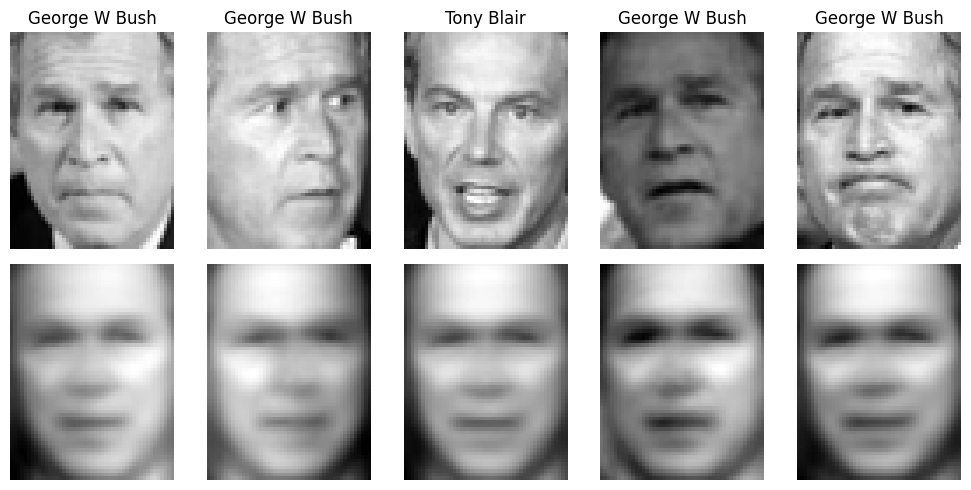

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(10,5))
n_images = 5
print(lfw_people.images.shape)
X = lfw_people.images.reshape((lfw_people.images.shape[0], lfw_people.images.shape[1] * lfw_people.images.shape[2]))
# YOUR CODE HERE
for i in range(n_images):
    # Original images
    original_image = scaler.inverse_transform(X_test[i].reshape(1, -1)).reshape(lfw_people.images.shape[1], lfw_people.images.shape[2])
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(target_names[y_test[i]])
    axes[0, i].axis('off')

    # Reconstructed images
    reconstructed_image = scaler.inverse_transform(test_recon_kpca[i].reshape(1, -1)).reshape(lfw_people.images.shape[1], lfw_people.images.shape[2])
    axes[1, i].imshow(reconstructed_image, cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Autoencoder neural network

An autoencoder is a type of neural network in which the outputs are the same as the inputs. In other words, the goal of the network is to reconstruct the original input image by minimizing the mean squared error loss function. The autoencoder consists of two main components: an encoder network that maps the input data to a low dimensional representation $z$ and a decoder network that maps $z$ back to the original dimension.

In the code below, we implement a simple autoencoder network using dense (feed-forward) layers and train it using our LFW faces dataset.

In [ ]:
import tensorflow as tf
seed = 256
tf.keras.utils.set_random_seed(seed)

import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32

# This is our input image
input_img = keras.Input(shape=(X_train.shape[1],))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(X_train.shape[1], activation='sigmoid')(decoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In addition to the full autoencoder model, we can construct the encoder and decoder models separately. Here we will construct the encoder model so that we can use it to reduce the data dimensionality without having to also reconstruct the data (which is done by `autoencoder`).

In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

Next we compile the model. We'll use the Adam optimizer and mean squared error loss.

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

Now we train our model. Below we train for 100 epochs using a batch size of 32.

In [ ]:
autoencoder.fit(x=X_train, y=X_train,
                epochs=100,
                batch_size=32,
                shuffle=True)

Epoch 1/100
29/29 [==============================] - 2s 15ms/step - loss: 0.9905
Epoch 2/100
29/29 [==============================] - 0s 14ms/step - loss: 0.8716
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.8134
Epoch 4/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7930
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7818
Epoch 6/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7690
Epoch 7/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7587
Epoch 8/100
29/29 [==============================] - 0s 15ms/step - loss: 0.7509
Epoch 9/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7438
Epoch 10/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7368
Epoch 11/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7343
Epoch 12/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7278
Epoch 13/100
29/29 [=====

**Question 2: In the code above, why did we set x and y both equal to `X_train`?**

**Answer:**

In an autoencoder, both the input, x, and the target, y, are assigned the value of X_train. This setup reflects the autoencoder's goal of learning a compressed representation of the input data and then endeavoring to accurately reconstruct the input data from this compressed form.

The input x for the autoencoder is the original data, X_train, consisting of flattened images of faces. Similarly, the target y that the autoencoder aims to replicate is also X_train. This is because the autoencoder is designed to produce an output that mirrors the input as closely as possible.

Therefore, the objective of the autoencoder is to discover a function that effectively maps its input back onto itself (acts as an identity function). It does so by initially compressing the data into a more compact, lower-dimensional space (encoding) and subsequently expanding it back to its original dimension (decoding).

Now we have our trained autoencoder for which the input is an image and the output is the reconstruction. Next we use our trained autoencoder to reconstruct the test images.

In [ ]:
test_recon_ae = autoencoder.predict(X_test)

13/13 [==============================] - 0s 4ms/step


In the cell below, visualize the same 5 as we did for KernelPCA. You can copy the same code as the previous code block used for visualization and add a fourth row for the autoencoder reconstructions.

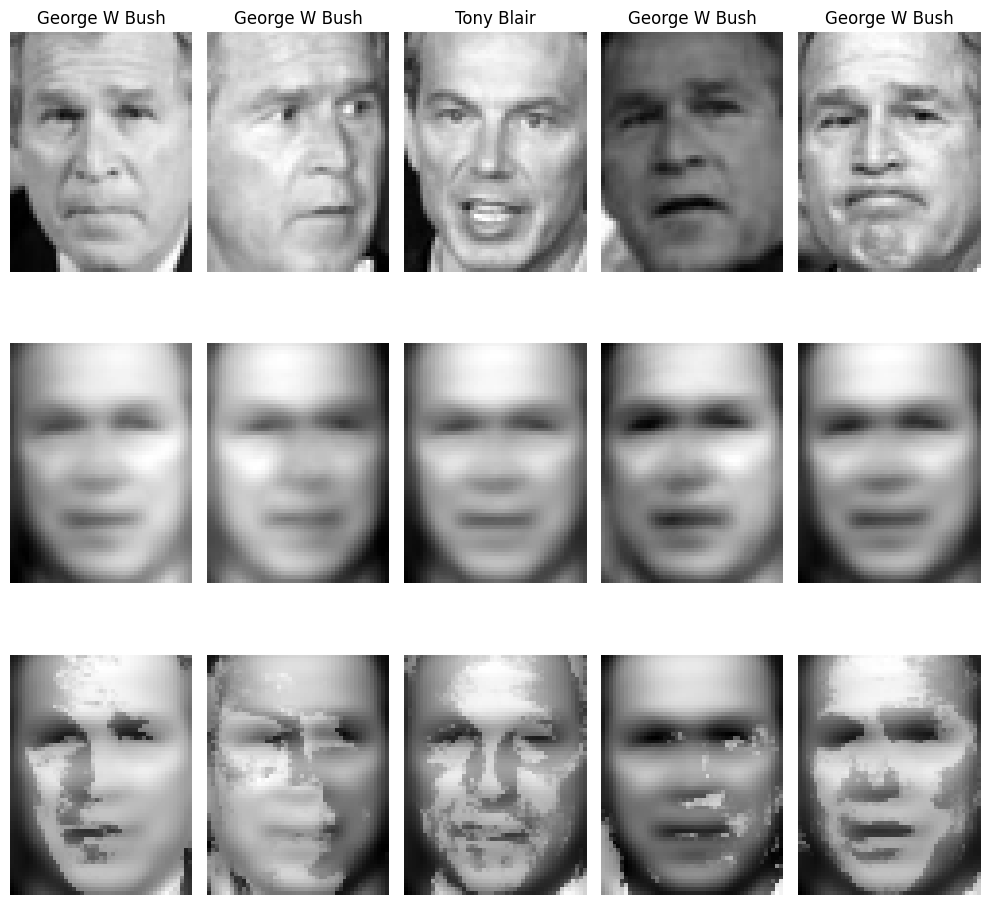

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(10, 10))  # Adjusted for 4 rows: original, KPCA, AE

for i in range(n_images):
    # Original images
    original_image = scaler.inverse_transform(X_test[i].reshape(1, -1)).reshape(lfw_people.images.shape[1], lfw_people.images.shape[2])
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(target_names[y_test[i]])
    axes[0, i].axis('off')

    # Reconstructed images from KernelPCA
    reconstructed_image_kpca = scaler.inverse_transform(test_recon_kpca[i].reshape(1, -1)).reshape(lfw_people.images.shape[1], lfw_people.images.shape[2])
    axes[1, i].imshow(reconstructed_image_kpca, cmap='gray')
    axes[1, i].axis('off')

    # Placeholders for consistency with initial question
    # axes[2, i].axis('off')  # This might be a placeholder or another visualization you had in mind

    # Reconstructed images from Autoencoder
    reconstructed_image_ae = scaler.inverse_transform(test_recon_ae[i].reshape(1, -1)).reshape(lfw_people.images.shape[1], lfw_people.images.shape[2])
    axes[2, i].imshow(reconstructed_image_ae, cmap='gray')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


**Question 3: The reconstructions by the autoencoder do not look as accurate as the reconstructions by the PCA and KernelPCA models. This does not mean that linear or kernel PCA is inherently better than an autoencoder for reducing the dimensionality of this dataset---it is probable that if we spent time tuning all the hyperparameters of the autoencoder, we would find a model that has a better solution. However, there are many more hyperparameters to tune in the autoencoder compared to the PCA models. List at least three hyperparameters that could be optimized for the autoencoder.**

**Answer:**

At least three hyperparameters that could be optimized in an autoencoder are:

Number of Layers and Neurons per Layer: The architecture of the autoencoder,

1.   specifically the number of hidden layers and the number of neurons in each layer, is crucial. This includes both the encoder and decoder parts of the model. Adding more layers or neurons can increase the model's capacity to learn more complex features, but it also risks overfitting and requires more data and training time.

2. Activation Functions: The choice of activation functions in the hidden layers affects the non-linearity introduced into the model, which in turn influences the model's ability to learn complex patterns in the data. Common choices include ReLU, sigmoid, and tanh. Each activation function has its characteristics and use cases, and experimenting with different activation functions can lead to improvements in model performance.

3. Learning Rate and Optimizer: The learning rate controls how much the model's weights are updated during training. A too high learning rate can cause the model to converge too quickly to a suboptimal solution, while a too low learning rate can make the training process very slow. Optimizers like Adam, SGD (Stochastic Gradient Descent), and RMSprop can also significantly impact the training dynamics and the final model performance. Some optimizers are better suited for specific types of models and data distributions.

**Question 4: The autoencoder we implemented here used feed-forward/dense layers. Another way to improve the autoencoder reconstruction could be to use a different type of layer. What other type of layer might give better performance (e.g., convolutional, recurrent) and why?**

**Answer:**

Using Convolutional Layers (in Convolutional Neural Networks, CNNs) can significantly enhance the performance of an autoencoder, especially when working with image data. Convolutional layers are designed to capture spatial hierarchies in the data by applying learnable filters to local patches of the input, making them highly effective for tasks involving images. This ability to recognize patterns like edges, textures, and shapes at various levels of abstraction allows a convolutional autoencoder to reconstruct input images with higher fidelity compared to a feed-forward/dense layer based autoencoder.

The convolutional layers focus on extracting local features through their receptive fields, and when stacked, these layers can learn increasingly complex patterns. This is particularly beneficial for images where such spatial relationships are key to the data's structure. Additionally, convolutional layers can reduce the number of parameters required in the model due to their shared weights, making the network more efficient and easier to train.

For temporal sequence data (e.g., time series, video, or text), Recurrent Neural Network layers (RNNs), especially those with Long Short-Term Memory (LSTM) or Gated Recurrent Unit (GRU) cells, could offer improvements. These layers are capable of capturing dependencies and patterns over time by maintaining a memory of previous inputs. This makes them well-suited for autoencoding tasks where the input data has a temporal dimension.

In summary, choosing the type of layer (convolutional for spatial data like images or recurrent for temporal sequence data) aligns with the intrinsic structure of the input data, potentially leading to better performance in autoencoding tasks by more effectively capturing and reconstructing the complex patterns present in the data.
